In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Conv2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

def load_dataset():
    # Base directories
    train_dir = "/kaggle/input/thermal-images-for-breast-cancer-diagnosis-dmrir/Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/Desenvolvimento da Metodologia"
    
    # Find the DOENTES and SAUDÁVEIS directories
    train_folders = os.listdir(train_dir)
    doentes_dir = os.path.join(train_dir, [folder for folder in train_folders if "DOENTES" in folder][0])
    saudaveis_dir = os.path.join(train_dir, [folder for folder in train_folders if "SAUD" in folder][0])
    
    # Function to load images from the "Segmentadas" subdirectories
    def load_images_from_segmentadas(directory, label):
        images = []
        labels = []
        
        for root, dirs, files in os.walk(directory):
            # Only process files inside "Segmentadas" subdirectories
            if "Segmentadas" in root:
                for file_name in files:
                    file_path = os.path.join(root, file_name)
                    
                    # Skip non-image files
                    if not file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                        continue
                    
                    # Preprocess the image
                    img = preprocess_image(file_path)
                    if img is not None:
                        images.append(img)
                        labels.append(label)
        
        return images, labels
    
    # Load images from both directories
    print("Loading cancer (DOENTES) images...")
    cancer_images, cancer_labels = load_images_from_segmentadas(doentes_dir, 1)
    
    print("Loading healthy (SAUDÁVEIS) images...")
    healthy_images, healthy_labels = load_images_from_segmentadas(saudaveis_dir, 0)
    
    # Combine datasets
    all_images = cancer_images + healthy_images
    all_labels = cancer_labels + healthy_labels
    
    # Convert to numpy arrays
    X = np.array(all_images)
    y = np.array(all_labels)
    
    # Print the shape before conversion
    print(f"Dataset shape before RGB conversion: {X.shape}")
    
    # Convert grayscale to RGB (duplicate channels)
    if X.ndim == 3:  # If shape is (n, 224, 224)
        X = np.stack([X, X, X], axis=-1)
    
    # Print the shape after conversion
    print(f"Dataset shape after RGB conversion: {X.shape}")
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test


# Function to preprocess images
def preprocess_image(img_path):
    # Read image in grayscale mode
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        return None
    
    # Noise reduction using median filtering
    img = cv2.medianBlur(img, 3)
    
    # Resize to 224x224 (standard for CNNs)
    img = cv2.resize(img, (224, 224))
    
    # Normalize pixel values to [0, 1]
    img = img.astype('float32') / 255.0
    
    # Convert grayscale to RGB (duplicate the channels)
    img = np.stack([img, img, img], axis=-1)
    
    return img


In [10]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from tensorflow.keras.metrics import AUC
import matplotlib.pyplot as plt
import numpy as np

def cohen_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred)

def build_vgg19_feature_extractor():
    input_shape = (224, 224, 3)
    input_tensor = Input(shape=input_shape)
    base_model = VGG19(weights='imagenet', include_top=False, input_tensor=input_tensor)
    
    for layer in base_model.layers:
        layer.trainable = False
    
    model = Model(inputs=input_tensor, outputs=base_model.output)
    
    return model

def find_optimal_threshold(y_true, y_pred_probs):
    # Method to find the optimal threshold based on maximizing F1-score or other metrics
    best_threshold = 0.5
    best_f1_score = 0

    for threshold in np.arange(0.1, 1.0, 0.05):
        y_pred_binary = (y_pred_probs > threshold).astype(int)
        report = classification_report(y_true, y_pred_binary, output_dict=True)
        f1_score = report['1']['f1-score']  # F1-score for the positive class (cancer)
        
        if f1_score > best_f1_score:
            best_f1_score = f1_score
            best_threshold = threshold
    
    return best_threshold

def train_and_evaluate(X_train, X_test, y_train, y_test):
    # Build feature extractor
    feature_extractor = build_vgg19_feature_extractor()
    
    # Add custom classification layers on top
    x = feature_extractor.output
    x = Flatten()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)  # Binary classification (cancer or not)
    
    model = Model(inputs=feature_extractor.input, outputs=output)
    
    # Compile the model
    model.compile(
        optimizer=Adamax(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', AUC()]
    )
    
    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_breast_cancer_model.keras', monitor='val_accuracy', 
                                       save_best_only=True, mode='max')
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=50,
        batch_size=32,
        callbacks=[early_stopping, model_checkpoint]
    )
    
    model.save('my_model.h5')
    
    # Evaluate the model
    ''''evaluation_results = model.evaluate(X_test, y_test)
    test_loss = evaluation_results[0]
    test_accuracy = evaluation_results[1]
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")'''
    # Evaluate the model
    evaluation_results = model.evaluate(X_test, y_test)
    
    # Unpack the results based on the number of metrics you've defined in the model
    test_loss = evaluation_results[0]
    test_accuracy = evaluation_results[1]
    test_auc = evaluation_results[2]  # This handles the AUC metric
    
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test AUC: {test_auc:.4f}")

    # Calculate additional metrics
    y_pred_probs = model.predict(X_test).flatten()  # Get raw probabilities (not binary)
    
    # Find the best threshold for classification
    optimal_threshold = find_optimal_threshold(y_test, y_pred_probs)
    print(f"Optimal Threshold: {optimal_threshold:.2f}")
    
    # Apply the optimal threshold
    y_pred_binary = (y_pred_probs > optimal_threshold).astype(int)

    # Cohen's Kappa Score
    kappa = cohen_kappa(y_test, y_pred_binary)
    print(f"Cohen's Kappa: {kappa:.4f}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_binary))
    
    # Confusion Matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred_binary)
    print(cm)
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()
    
    return model


In [7]:
# Load and preprocess dataset
print("Loading and preprocessing the dataset...")
X_train, X_test, y_train, y_test = load_dataset() 

Loading and preprocessing the dataset...
Loading cancer (DOENTES) images...
Loading healthy (SAUDÁVEIS) images...
Dataset shape before RGB conversion: (1282, 224, 224, 3)
Dataset shape after RGB conversion: (1282, 224, 224, 3)


Training the model...
Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 228ms/step - accuracy: 0.6616 - auc_1: 0.7114 - loss: 1.5864 - val_accuracy: 0.8716 - val_auc_1: 0.9604 - val_loss: 0.9772
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.8374 - auc_1: 0.9223 - loss: 0.9948 - val_accuracy: 0.9261 - val_auc_1: 0.9717 - val_loss: 0.7608
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.8929 - auc_1: 0.9559 - loss: 0.7783 - val_accuracy: 0.9183 - val_auc_1: 0.9809 - val_loss: 0.6675
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.9021 - auc_1: 0.9636 - loss: 0.6798 - val_accuracy: 0.9533 - val_auc_1: 0.9807 - val_loss: 0.5834
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.9310 - auc_1: 0.9749 - loss: 0.6021 - val_accuracy: 0.9339 - val_auc_1: 0.9887 - val_loss: 0.5393
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.9504 - auc_1: 0.9846 - loss: 0.5445 - val_accuracy: 0.9455 - val_auc_1: 0.9931 - val_loss: 

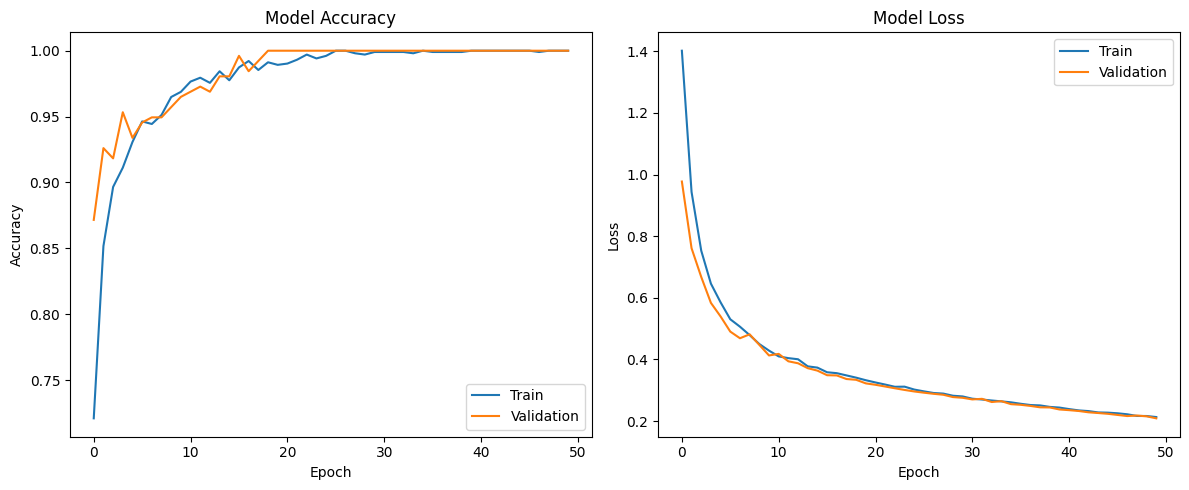

Training and evaluation completed.


In [11]:
 # Train and evaluate the model
print("Training the model...")
model = train_and_evaluate(X_train, X_test, y_train, y_test)
    
print("Training and evaluation completed.")


In [32]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 58,562,629 (223.40 MB)

 Trainable params: 12,846,081 (49.00 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

 Optimizer params: 25,692,164 (98.01 MB)